In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cma

# Defining Model Curves

### Pruning vs Accuracy

In [1433]:
def get_accuracy(p):
    b0 = 92.75
    b1 = 164.9
    b2 = -2347
    b3 = 11118
    b4 = -23518
    b5 = 22982
    b6 = -8483

    return b0 + b1 * p + b2 * p**2 + b3 * p**3 + b4 * p**4 + b5 * p**5 + b6 * p**6

### Pruning vs Model Size

In [1434]:
def get_size(p):
    b1 = -427.4
    b0 = 480.4
    
    return b0 + b1 * p

### Pruning vs Inference Time

In [1435]:
def get_time(p):
    b0 = 1.020
    b1 = -1.417
    b2 = 3.677
    b3 = -3.275
    
    return b0 + b1 * p + b2 * p**2 + b3 * p**3

# Defining Rewards

### Accuracy Reward

In [1436]:
def get_accuracy_reward(curr_accuracy, min_accuracy, sigma_right=4, sigma_left=2):
    diff = curr_accuracy - min_accuracy
    if 0<=diff<=1e-2:
        return np.exp(- (diff**1.6) / (10 * sigma_left**2)) * 100
    else:
        return np.exp(- (abs(diff)**1.5) / (2 * sigma_right**2)) * 100

In [1437]:
min_accuracy = float(input("Enter the minimum acceptable accuracy: ") or 80.0)
acc_rewards = []
accuracies = []
pruning_amounts = np.arange(0.0, 1.001, 0.001)
for p in pruning_amounts:
    accuracy = get_accuracy(p)
    reward = get_accuracy_reward(accuracy, min_accuracy)
    accuracies.append(accuracy)
    acc_rewards.append(reward)

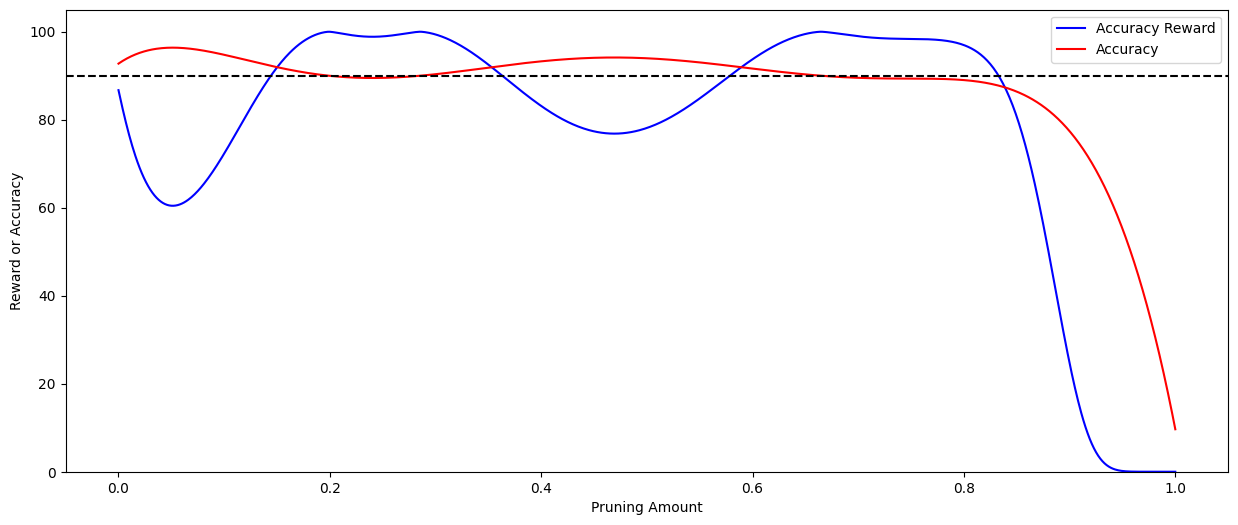

In [1438]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, acc_rewards, label='Accuracy Reward', color='blue')
plt.plot(pruning_amounts, accuracies, label='Accuracy', color='red')
plt.ylim(0)
plt.axhline(y=min_accuracy, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Reward or Accuracy')
plt.legend()

### Inference Time Reward

In [1439]:
def get_comp_time_reward(current_comp_time, sigma=0.8):
    return np.exp(- (current_comp_time**2) / (2 * sigma**2))*100

In [1440]:
time_rewards = []
comp_times = []
for p in pruning_amounts:
    time = get_time(p)
    reward = get_comp_time_reward(time)
    comp_times.append(time)
    time_rewards.append(reward)

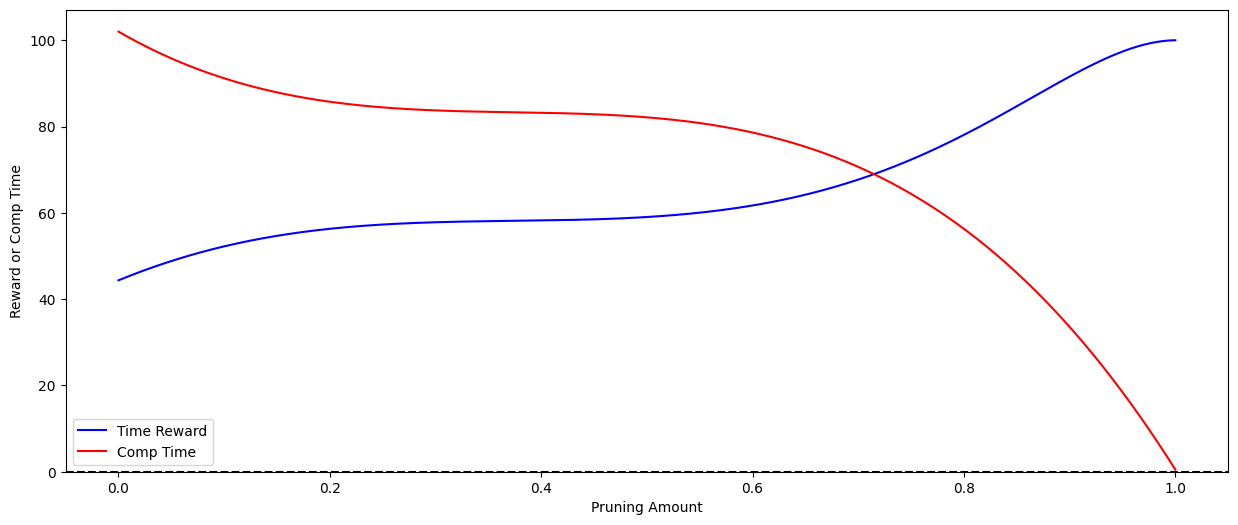

In [1441]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, time_rewards, label='Time Reward', color='blue')
plt.plot(pruning_amounts, [x * 100 for x in comp_times], label='Comp Time', color='red')
plt.ylim(0)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Reward or Comp Time')
plt.legend()

### Model Size Reward

In [ ]:
def get_model_size_reward(current_model_size, max_model_size, sigma_left=2):
    diff = current_model_size - max_model_size
    if current_model_size > max_model_size:
        return np.exp(- (abs(diff)**2) / (10 * sigma_left**2)) * 100
    if current_model_size == max_model_size:
        return 100
    else:
        return 100+(max_model_size/current_model_size)
    

In [1443]:
size_rewards = []
sizes = []
max_model_size = float(input("Enter the maximum acceptable model size: ") or 300.0)
for p in pruning_amounts:
    size = get_size(p)
    reward = get_model_size_reward(size, max_model_size)
    sizes.append(size)
    size_rewards.append(reward)

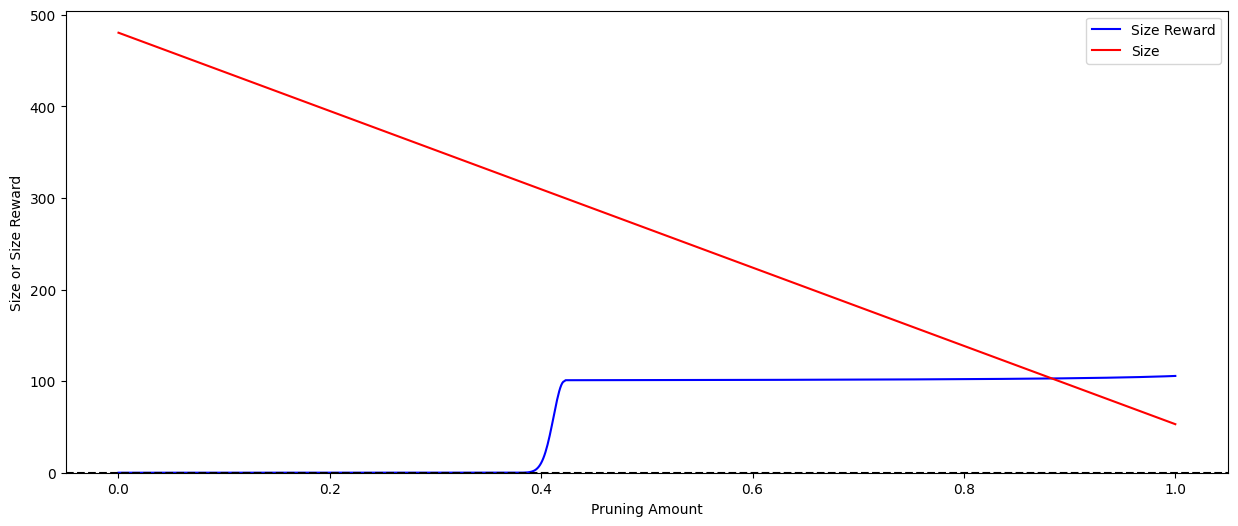

In [1444]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, size_rewards, label='Size Reward', color='blue')
plt.plot(pruning_amounts, sizes, label='Size', color='red')
plt.ylim(0)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Size or Size Reward')
plt.legend()

### Reward for better pruning

In [1445]:
def more_acc_less_size(accuracy, min_accuracy, size, max_model_size):
    if accuracy >= min_accuracy and size <= max_model_size:
        return ((accuracy-min_accuracy)*2) + (max_model_size-size)/2
    return 0

In [1446]:
counts_of_calulating_rewards = 0

### Final Reward Calculation

In [1447]:
def get_reward(p) -> float:
    accuracy = get_accuracy(p)
    time = get_time(p)
    size = get_size(p)
    
    acc_reward = np.array(get_accuracy_reward(accuracy, min_accuracy))
    time_reward = np.array(get_comp_time_reward(time))
    size_reward = np.array(get_model_size_reward(size, max_model_size))
    better_reward = more_acc_less_size(accuracy, min_accuracy, size, max_model_size)
    global counts_of_calulating_rewards
    counts_of_calulating_rewards += 1 # type: ignore
    
    return (acc_reward + time_reward + size_reward + better_reward + p*10).item()

In [1448]:
def get_details(p,):
    return {
        'Pruning Amount': p,
        "Accuracy": get_accuracy(p),
        "Time": get_time(p),
        "Size": get_size(p),
        "Accuracy Reward": get_accuracy_reward(get_accuracy(p), min_accuracy),
        "Time Reward": get_comp_time_reward(get_time(p)),
        "Size Reward": get_model_size_reward(get_size(p), max_model_size),
        "More Acc Less Size Reward": more_acc_less_size(get_accuracy(p), min_accuracy, get_size(p), max_model_size),
        "Pruning Reward": p * 100,
        "Total Reward": get_reward(p),
    }

# Global Optimization with CMA-ES
Here we apply the CMA-ES evolutionary strategy for robust, gradient-free maximization of the total reward over the pruning amount.

In [ ]:
def objective(x):
    p = x[0]
    return -1 * get_reward(p)

x0 = [0.5, 0.0]
sigma = 0.4
bounds = [[0.0, -float('inf')], [1.0, float('inf')]]

es = cma.CMAEvolutionStrategy(x0, sigma, {
    'bounds': bounds,
    'popsize': 20
})

for _ in range(100):
    candidates = es.ask()
    fitnesses = [objective(c) for c in candidates]
    es.tell(candidates, fitnesses)

opt_p = es.result.xbest[0]
print(f"CMA-ES found optimal pruning amount: {opt_p:.4f}")
print(f"Maximum reward: {-es.result.fbest:.4f}")
print(f"Number of reward calculations: {counts_of_calulating_rewards}") # type: ignore

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 2 (seed=867646, Tue Jun 24 13:32:01 2025)
NOTE (module=cma, iteration=31):  
condition in coordinate system exceeded 1.9e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+08 to 1.1e+00
NOTE (module=cma, iteration=69):  
condition in coordinate system exceeded 1.4e+08, rescaled to 1.0e+00, 
condition changed from 9.5e+07 to 1.7e+00
CMA-ES found optimal pruning amount: 0.6647
Maximum reward: 325.1527
Number of reward calculations: 2000


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/evolution_strategy.py:1244: UserWarning: Sampling standard deviation i=0 at iteration 0 change by 0.8333333333333333 to stds[0]=0.3333333333333333
  warnings.warn("Sampling standard deviation i={0} at iteration {1}"


In [1450]:
rewards = [get_reward(p) for p in pruning_amounts]
max_index = np.argmax(rewards)
max_reward = rewards[max_index]

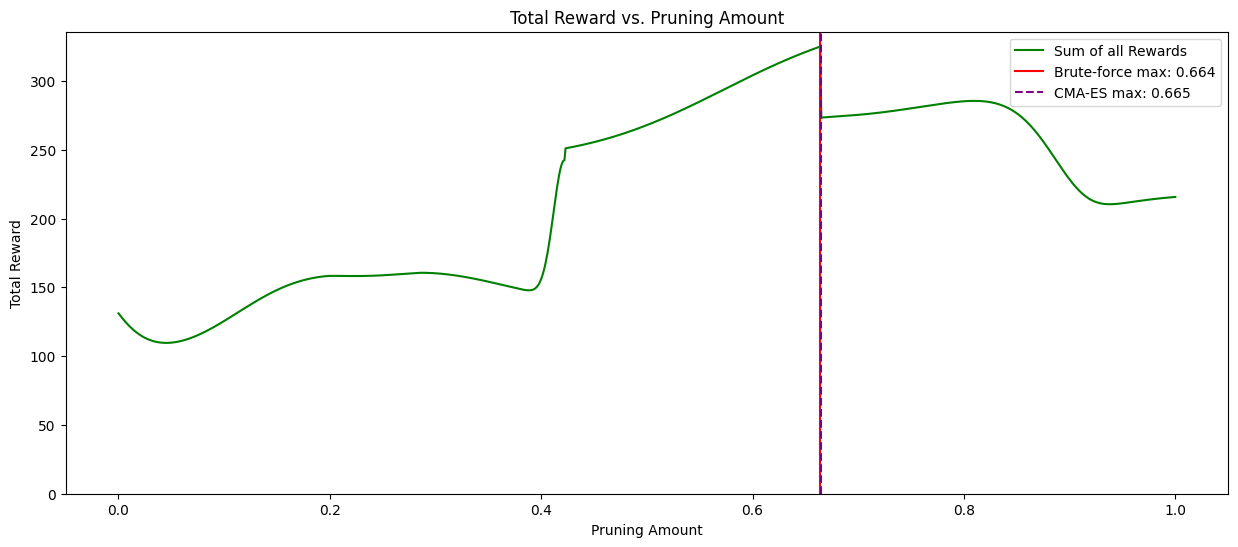

Brute-force search optimal pruning amount: 0.6640
CMA-ES found optimal pruning amount: 0.6647
Reward at brute-force optimum: 324.96
Reward at CMA-ES optimum: 325.15


In [1451]:
# Plotting the results to compare brute-force and CMA-ES
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, rewards, label='Sum of all Rewards', color='green')

# Brute-force result
brute_force_p = pruning_amounts[max_index]
plt.axvline(x=brute_force_p, color='red', linestyle='-', label=f'Brute-force max: {brute_force_p:.3f}')

# CMA-ES result
plt.axvline(x=opt_p, color='purple', linestyle='--', label=f'CMA-ES max: {opt_p:.3f}')

plt.ylim(0)
plt.xlabel('Pruning Amount')
plt.ylabel('Total Reward')
plt.title('Total Reward vs. Pruning Amount')
plt.legend()
plt.show()

print(f"Brute-force search optimal pruning amount: {brute_force_p:.4f}")
print(f"CMA-ES found optimal pruning amount: {opt_p:.4f}")

# Also print the rewards at these points
reward_brute_force = get_reward(brute_force_p)
reward_cma_es = get_reward(opt_p)

print(f"Reward at brute-force optimum: {reward_brute_force:.2f}")
print(f"Reward at CMA-ES optimum: {reward_cma_es:.2f}")

In [1452]:
get_details(opt_p)

{'Pruning Amount': np.float64(0.6647209599548739),
 'Accuracy': np.float64(90.0),
 'Time': np.float64(0.7408885003914979),
 'Size': np.float64(196.2982617152869),
 'Accuracy Reward': np.float64(100.0),
 'Time Reward': np.float64(65.12638330827129),
 'Size Reward': np.float64(101.52828658480493),
 'More Acc Less Size Reward': np.float64(51.850869142356544),
 'Pruning Reward': np.float64(66.4720959954874),
 'Total Reward': 325.15274863498144}

In [1453]:
get_details(brute_force_p)

{'Pruning Amount': np.float64(0.664),
 'Accuracy': np.float64(90.01339484629955),
 'Time': np.float64(0.7415141504000001),
 'Size': np.float64(196.60639999999995),
 'Accuracy Reward': np.float64(99.99515553186352),
 'Time Reward': np.float64(65.07921098158717),
 'Size Reward': np.float64(101.52589132398539),
 'More Acc Less Size Reward': np.float64(51.72358969259912),
 'Pruning Reward': np.float64(66.4),
 'Total Reward': 324.9638475300352}

# Importance of Each View

In [1467]:
importance_values = {
    'view 0':  23.518203735351562,
    'view 1':  22.247163772583008,
    'view 2':  17.184127807617188,
    'view 3':  21.088960647583008,
    'view 4':  20.715179443359375,
    'view 5':  20.43429183959961,
    'view 6':  19.613994598388672,
    'view 7':  19.81046485900879,
    'view 8':  20.519678115844727,
    'view 9':  18.430849075317383,
    'view 10': 15.866874694824219,
    'view 11': 13.570204734802246,
}
importance_values = sorted(importance_values.items(), key=lambda x: x[1], reverse=True)

In [1468]:
importance_values = dict(importance_values)

In [1469]:
importance_values = {view: 10 / value for view, value in importance_values.items()}

In [1470]:
importance_values

{'view 0': 0.42520254150908754,
 'view 1': 0.4494954998409197,
 'view 3': 0.47418173740800706,
 'view 4': 0.4827377927061926,
 'view 8': 0.4873370792438638,
 'view 5': 0.48937345509674096,
 'view 7': 0.5047837126069513,
 'view 6': 0.5098400506759352,
 'view 9': 0.542568601106501,
 'view 2': 0.5819323571119689,
 'view 10': 0.6302438377018257,
 'view 11': 0.7369085577871886}